<a href="https://colab.research.google.com/github/bhanuchaddha/The-Ai-Handbook/blob/main/4-AI-Agents/automatic_event_planner/Multi_Agent_Automatice_Event_Planner_using_CrewAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Agent Event Management System with AI

## Introduction

### Welcome to the Future of Event Management!

Imagine an application that takes the heavy lifting out of planning your next big event. Here’s how it works:

1. **Venue Discovery:** It analyzes your requirements like capacity, budget, and city to shortlist the perfect venues for your event.
2. **Availability Check:** From the shortlisted venues, it selects the ones available on your desired date.
3. **Logistics Planning:** It finds the best companies or agencies to handle catering, transportation, and equipment needs seamlessly.
4. **Marketing Strategy:** Using the type of your conference, it crafts a robust organizational and marketing plan, ensuring maximum engagement and visibility.

This AI application transforms chaos into clarity, making event management smarter, faster, and hassle-free. Let's dive in!

## System Architecture

### Application Flow

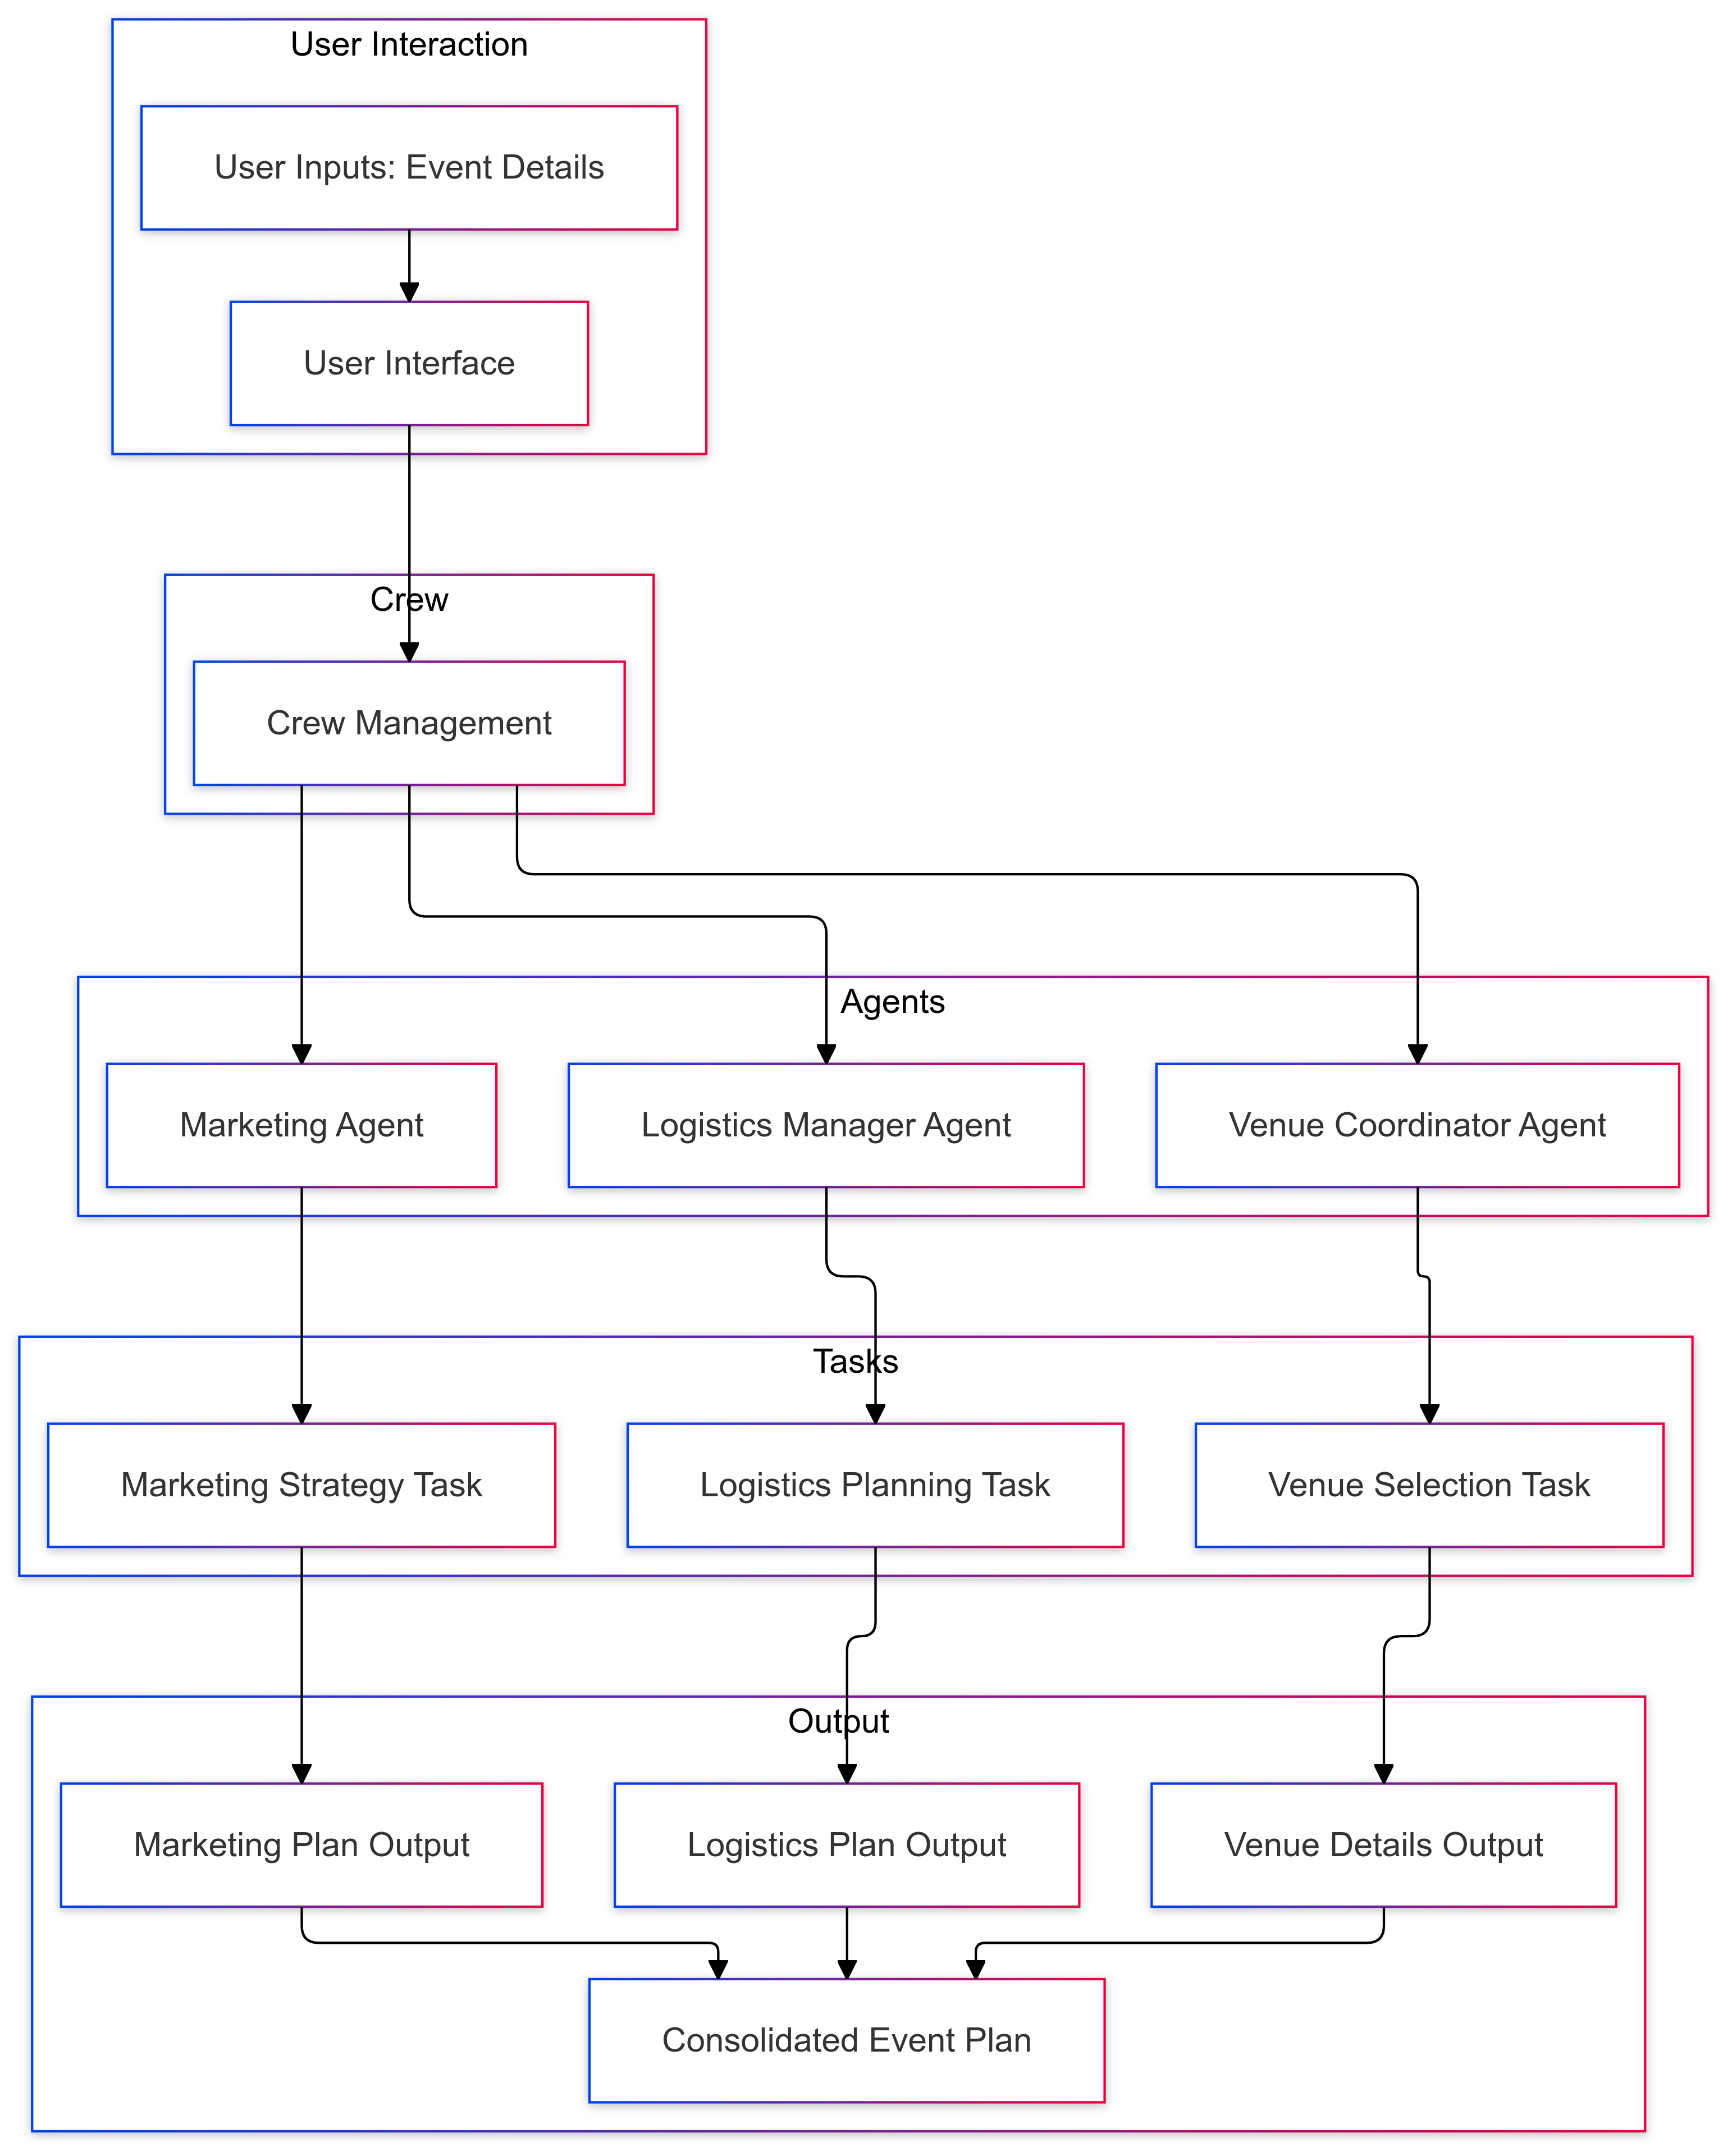

### Component Interaction

1. **Venue Coordinator**: Identifies and secures the ideal venue based on event requirements.
2. **Logistics Manager**: Plans and manages transportation, catering, and equipment.
3. **Marketing Agent**: Develops and executes a marketing strategy to maximize event visibility.

### Key Technical Decisions

- **Agent Roles**: Each agent focuses on a distinct domain for modularity and efficiency.
- **AI Integration**: Decision-making logic relies on natural language processing and automation.
- **System Workflow**: Sequential task execution with feedback loops for error handling.

## Technical Deep Dive

### Agent Roles and Responsibilities

1. **Venue Coordinator**:
   - Tools: Search and scrape utilities for venue exploration.
   - Outputs: Venue details including name, address, capacity, and booking status.

2. **Logistics Manager**:
   - Tools: Automated communication with vendors and scheduling systems.
   - Outputs: Comprehensive logistics plans with resource allocations.

3. **Marketing Agent**:
   - Tools: Social media schedulers, email automation, and analytics.
   - Outputs: Multi-channel marketing strategies and execution plans.

### System Workflow

1. Event details are input into the system.
2. The Venue Coordinator identifies potential venues.
3. The Logistics Manager develops detailed logistics plans.
4. The Marketing Agent creates and executes a marketing strategy.
5. The system consolidates outputs into a unified event plan.

### Key Algorithms

- **Venue Selection**: Filters venues based on capacity, location, and budget using weighted scoring.
- **Logistics Optimization**: Employs linear programming to minimize costs while maximizing service quality.
- **Marketing Campaign Strategy**: Utilizes sentiment analysis to refine messaging.

## Target Audience

- **Primary Users**: Event organizers, project managers, and marketing teams.
- **Skill Level**: Intermediate to advanced technical expertise.
- **Use Cases**: Conferences, product launches, and corporate events.
- **Industry Applications**: Hospitality, corporate services, and marketing agencies.

## Technology Stack

- **Core Technologies**: Python, LangChain, CrewAI
- **Libraries and Frameworks**:
  - Gradio for UI
  - Pydantic for data validation
- **Dependencies**: OpenAI models, web scraping libraries
- **Architecture Patterns**: Modular, agent-based
- **Documentation**: [LangChain](https://langchain.com/docs), [Gradio](https://gradio.app/docs)

## Implementation Guide

### Prerequisites
- Python 3.9 or higher
- Virtual environment setup

## Setup

In [ ]:
!pip install crewai crewai-tools gradio

In [ ]:
from crewai import Agent, Task, Crew

In [ ]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')
os.environ['SERPER_API_KEY']=userdata.get('SERPER_API_KEY')

In [ ]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

In [ ]:
from crewai import Agent, Task, Crew

## Defining Agents

In [ ]:
from pydantic import BaseModel
from pprint import pprint

# Define Agents
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue based on event requirements.",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and understanding of event logistics, you excel at finding and securing the perfect venue that fits the event's theme, size, and budget constraints."
    )
)

logistics_manager = Agent(
    role="Logistics Manager",
    goal="Manage all logistics for the event, including catering and equipment.",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, you ensure that every logistical aspect of the event from catering to equipment setup is flawlessly executed to create a seamless experience."
    )
)

marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Develop a comprehensive marketing and communications plan to maximize event visibility and engagement.",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, you craft compelling messages and engage with potential attendees to maximize event exposure and participation."
    )
)

## Defining Tasks

In [ ]:
# Define VenueDetails Pydantic model
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

# Define Tasks
venue_task = Task(
    description="Identify a suitable venue in {event_city} that meets the criteria for {event_topic}, including size, location, and budget.",
    expected_output="Details of a suitable venue, including name, address, capacity, and booking status.",
    output_json=VenueDetails,
    agent=venue_coordinator
)

logistics_task = Task(
    description="Coordinate catering, transportation, and equipment for an event with {expected_participants} participants on {tentative_date}. Ensure all logistical aspects are aligned with the event schedule and goals.",
    expected_output="Comprehensive logistics plan covering catering, transportation, and equipment setup details.",
    agent=logistics_manager
)

marketing_task = Task(
    description="Develop a multi-channel marketing plan for the event '{event_topic}' to engage at least {expected_participants} potential attendees. Include social media, email campaigns, partnerships, and pre-event content strategies.",
    expected_output="Detailed marketing plan with timelines, channels, and specific actions for promoting the event.",
    agent=marketing_communications_agent
)



## Assembling Crew

In [ ]:
# Define the Crew
event_management_crew = Crew(
    agents=[
        venue_coordinator,
        logistics_manager,
        marketing_communications_agent
    ],
    tasks=[
        venue_task,
        logistics_task,
        marketing_task
    ],
    verbose=True
)

# Event Details
# event_details = {
#     'event_topic': "Tech Innovation Conference",
#     'event_description': "A gathering of tech innovators and industry leaders to explore future technologies.",
#     'event_city': "Copenhagen",
#     'tentative_date': "2025-02-15",
#     'expected_participants': 100,
#     'budget': 20000,
#     'venue_type': "Conference Hall"
# }

# # Execute Tasks
# result = event_management_crew.kickoff(inputs=event_details)



# print("\n--- Comprehensive Marketing Plan ---")
# pprint(result)


## Gridio User Interface

In [25]:
import gradio as gr


def process_event(
    event_topic: str,
    event_description: str,
    event_city: str,
    tentative_date: str,
    expected_participants: int,
    budget: float,
    venue_type: str
) -> str:
    """Process event details and return the crew results."""
    try:
        event_details = {
            'event_topic': event_topic,
            'event_description': event_description,
            'event_city': event_city,
            'tentative_date': tentative_date,
            'expected_participants': expected_participants,
            'budget': budget,
            'venue_type': venue_type
        }

        # Get results from the crew
        result = event_management_crew.kickoff(inputs=event_details)
        return str(result)
    except Exception as e:
        return f"""
### Error in Event Processing
An error occurred while processing the event: {str(e)}
Please check your inputs and try again.
"""

# Create Gradio interface
with gr.Blocks(

    title="Multi-Agent Event Management System with AI",
    css="""
        .main-heading {
            text-align: center;
            font-size: 32px;
            font-weight: bold;
        }
        .hr {
            margin-top: 0px;
            margin-bottom: 20px;
        }
    """
  ) as app:
    gr.Markdown("<center><h1>Multi-Agent Event Management System with AI</h1></center>", elem_classes="main-heading")


    with gr.Row():
        with gr.Column():
            event_topic = gr.Textbox(
                label="Event Topic",
                placeholder="e.g., Tech Innovation Conference"
            )
            event_description = gr.Textbox(
                label="Event Description",
                lines=3,
                placeholder="Describe your event..."
            )
            event_city = gr.Textbox(
                label="Event City",
                placeholder="e.g., Copenhagen"
            )
            tentative_date = gr.Textbox(
                label="Tentative Date (YYYY-MM-DD)",
                placeholder="2025-02-15"
            )
            expected_participants = gr.Number(
                label="Expected Participants",
                value=100
            )
            budget = gr.Number(
                label="Budget",
                value=20000
            )
            # Using Dropdown for venue type as it's better UX
            venue_type = gr.Dropdown(
                label="Venue Type",
                choices=["Conference Hall", "Hotel Ballroom", "Outdoor Venue", "Meeting Room"],
                value="Conference Hall"
            )

            submit_btn = gr.Button("Generate Report")

    with gr.Row():
        output = gr.Markdown(label="Event Report")

    submit_btn.click(
        fn=process_event,
        inputs=[
            event_topic,
            event_description,
            event_city,
            tentative_date,
            expected_participants,
            budget,
            venue_type
        ],
        outputs=output
    )

# Launch the application
if __name__ == "__main__":
    app.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://abaf45ce233ad5d593.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Agent: Venue Coordinator
## Task: Identify a suitable venue in Copenhagen that meets the criteria for AI Innovation Conference, including size, location, and budget.


# Agent: Venue Coordinator
## Thought: I need to search for suitable venues in Copenhagen that can accommodate the AI Innovation Conference, focusing on size, location, and budget constraints.
## Using tool: Search the internet
## Tool Input: 
"{\"search_query\": \"Copenhagen venues for AI Innovation Conference\"}"
## Tool Output: 

Search results: Title: Upcoming event: Copenhagen AI Conference 2024 to Gather ...
Link: https://oresundstartups.com/upcoming-event-copenhagen-ai-conference-2024-to-gather-denmarks-top-ai-experts-founders-and-investors/
Snippet: Time: November 28, 18:00 – 21:00 · Place: Talent Garden Copenhagen, Danneskiold-Samsøes Allé 41, 1434 Copenhagen Denmark · Tickets: Copenhagen AI ...
---
Title: Artificial Intelligence and Machine Learning - Mindspace Conferences
Link: https://mindspaceconferences.c


### User Flow
1. Input event details.
2. Generate and review the event report.

## Usage Instructions

1. Input required event parameters.
2. Execute tasks using the Gradio interface.
3. Review outputs and refine inputs if necessary.

### Example Scenarios
- Planning a tech conference in Copenhagen.
- Organizing a corporate retreat with specific logistical requirements.

## Conclusion

The AI-driven multi-agent event management system streamlines the planning process, reducing manual effort and improving outcomes. Future enhancements could include real-time collaboration features and advanced analytics.

**Call to Action**: Try the system today and revolutionize your event planning experience.

## Resources

- [LangChain Documentation](https://langchain.com/docs)
- [Gradio Documentation](https://gradio.app/docs)
- [GitHub Repository](#)

